# Module version used

- torch 1.4.0
- numpy 1.18.1
- CPython 3.6.10
- IPython 7.12.0

- Runs on CPU or GPU (if available)

# Softmax Regression with MLxtend's plot_decision_regions on Iris

Implementation of softmax regression (multinomial logistic regression) and demonstration for how to use PyTorch models with MLxtend's [`plot_decision_regions`](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) function

## Imports

In [1]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
import numpy as np

## Settings and Dataset

In [13]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 0
learning_rate = 0.05
num_epochs = 100
batch_size = 8

# Architecture
num_features = 2
num_classes = 3

In [14]:
##########################
### DATASET
##########################

data = np.genfromtxt('data/iris.data', delimiter=',', dtype=str)
X, y = data[:, [2, 3]], data[:, 4]
X = X.astype(float)

d = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
y = np.array([d[x] for x in y])
y = y.astype(np.int)

print('Class label counts:', np.bincount(y))
print('X.shape:', X.shape)
print('y.shape:', y.shape)

# Shuffling & train/test split
shuffle_idx = np.arange(y.shape[0])
shuffle_rng = np.random.RandomState(123)
shuffle_rng.shuffle(shuffle_idx)
X, y = X[shuffle_idx], y[shuffle_idx]

X_train, X_test = X[shuffle_idx[:70]], X[shuffle_idx[70:]]
y_train, y_test = y[shuffle_idx[:70]], y[shuffle_idx[70:]]

# Normalize (mean zero, unit variance)
mu, sigma = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

Class label counts: [50 50 50]
X.shape: (150, 2)
y.shape: (150,)


In [15]:
##########################
### Data Loaders
##########################

from torch.utils.data import Dataset
from torch.utils.data import DataLoader



class MyDataset(Dataset):

    def __init__(self, X, y):
    
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.int64)

    def __getitem__(self, index):
        training_example, training_label = self.X[index], self.y[index]
        return training_example, training_label

    def __len__(self):
        return self.y.shape[0]
    
    
train_dataset = MyDataset(X[:100], y[:100])
test_dataset = MyDataset(X[100:], y[100:])


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True, # want to shuffle the dataset
                          num_workers=4) # number processes/CPUs to use

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         num_workers=4)

In [16]:
##########################
### MODEL
##########################

class SoftmaxRegression(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(SoftmaxRegression, self).__init__()
        self.linear = torch.nn.Linear(num_features, num_classes)
        
        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()
        
    def forward(self, x):
        logits = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

model = SoftmaxRegression(num_features=num_features,
                          num_classes=num_classes)

model.to(device)

##########################
### COST AND OPTIMIZER
##########################

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [17]:
# Manual seed for deterministic data loader
torch.manual_seed(random_seed)


def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    
    for features, targets in data_loader:
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
        
    return correct_pred.float() / num_examples * 100
    

for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
        targets = targets.to(device)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        
        # note that the PyTorch implementation of
        # CrossEntropyLoss works with logits, not
        # probabilities
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_dataset)//batch_size, cost))
            
    with torch.set_grad_enabled(False):
        print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader)))

Epoch: 001/100 | Batch 000/012 | Cost: 1.0986
Epoch: 001/100 training accuracy: 44.00%
Epoch: 002/100 | Batch 000/012 | Cost: 0.9489
Epoch: 002/100 training accuracy: 66.00%
Epoch: 003/100 | Batch 000/012 | Cost: 0.8236
Epoch: 003/100 training accuracy: 72.00%
Epoch: 004/100 | Batch 000/012 | Cost: 0.8275
Epoch: 004/100 training accuracy: 95.00%
Epoch: 005/100 | Batch 000/012 | Cost: 0.6650
Epoch: 005/100 training accuracy: 72.00%
Epoch: 006/100 | Batch 000/012 | Cost: 0.6465
Epoch: 006/100 training accuracy: 78.00%
Epoch: 007/100 | Batch 000/012 | Cost: 0.3825
Epoch: 007/100 training accuracy: 95.00%
Epoch: 008/100 | Batch 000/012 | Cost: 0.4917
Epoch: 008/100 training accuracy: 77.00%
Epoch: 009/100 | Batch 000/012 | Cost: 0.6003
Epoch: 009/100 training accuracy: 81.00%
Epoch: 010/100 | Batch 000/012 | Cost: 0.5938
Epoch: 010/100 training accuracy: 93.00%
Epoch: 011/100 | Batch 000/012 | Cost: 0.3073
Epoch: 011/100 training accuracy: 93.00%
Epoch: 012/100 | Batch 000/012 | Cost: 0.35

Epoch: 095/100 training accuracy: 95.00%
Epoch: 096/100 | Batch 000/012 | Cost: 0.0872
Epoch: 096/100 training accuracy: 96.00%
Epoch: 097/100 | Batch 000/012 | Cost: 0.1350
Epoch: 097/100 training accuracy: 96.00%
Epoch: 098/100 | Batch 000/012 | Cost: 0.0669
Epoch: 098/100 training accuracy: 96.00%
Epoch: 099/100 | Batch 000/012 | Cost: 0.1377
Epoch: 099/100 training accuracy: 96.00%
Epoch: 100/100 | Batch 000/012 | Cost: 0.1569
Epoch: 100/100 training accuracy: 96.00%


In [18]:
print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 96.00%


## Creating a ModelWrapper class for plot_decision_regions

All we need is a simple class that implements a `predict` method. That's it.

In [19]:
class ModelWrapper():
    def __init__(self, model, device):
        self.model = model
        self.device = device
        
    def predict(self, X):
        features = torch.tensor(X, dtype=torch.float32, device=self.device)
        logits, probas = self.model(features)
        _, predicted_labels = torch.max(probas, 1)
        
        return predicted_labels.numpy()

In [20]:
mymodel = ModelWrapper(model, device=torch.device('cpu'))

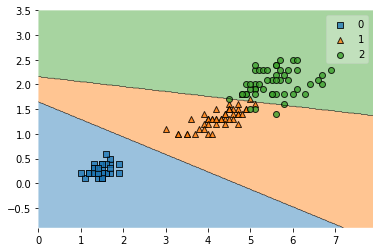

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

plot_decision_regions(X, y, mymodel)
plt.show()